# SpikeInterface DEMO v0.98 -  Neuralnet - October 2022

For this demo we will use a small file provided by Eduarda Centeno, Arthur Leblois and Aude Retailleau from IMN lab in Bordeaux.
It is a recording from a zebra finch for testing the probe ASSY-236-H5 from cambridge neurotech.
The recording system is the openephys usb3 board.
This file is only for testing or teaching purposes.


# Table of contents

* [0. Preparation](#preparation)
* [1. Reading recording and sorting](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Data compression](#compression)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Viewers](#viewers)
* [9. Spike sorting comparison](#comparison)
* [10. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data



In [1]:
import spikeinterface.full as si


In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.98.0.dev0


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.simplefilter("ignore")

# %matplotlib widget
%matplotlib inline

# 1. Reading recording and sorting <a class="anchor" id="loading"></a>

In [19]:
base_folder = Path('/data_local/DataSpikeSorting/SI_tutorial_marseille_2023')
oe_folder = base_folder / 'openephys_recording/2023-08-23_15-56-05'


In [20]:
full_raw_rec = si.read_openephys(oe_folder)


The `read_openephys()` function returns a `Recording` (or `RecordingExtractor`) object. We can print it to visualize some of its properties:

In [21]:
full_raw_rec

OpenEphysBinaryRecordingExtractor: 72 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                                   300.00s (5.00 minutes) - int16 dtype - 1.21 GiB

`spikeinterface.extractors` integrate many readers

In [22]:
si.recording_extractor_full_dict

{'binaryfolder': spikeinterface.core.binaryfolder.BinaryFolderRecording,
 'binary': spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 'zarr': spikeinterface.core.zarrrecordingextractor.ZarrRecordingExtractor,
 'numpy': spikeinterface.core.numpyextractors.NumpyRecording,
 'shybrid': spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 'mda': spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 'nwb': spikeinterface.extractors.nwbextractors.NwbRecordingExtractor,
 'cbin_ibl': spikeinterface.extractors.cbin_ibl.CompressedBinaryIblExtractor,
 'ibl_streaming_recording': spikeinterface.extractors.iblstreamingrecording.IblStreamingRecordingExtractor,
 'mcsh5': spikeinterface.extractors.mcsh5extractors.MCSH5RecordingExtractor,
 'alphaomega': spikeinterface.extractors.neoextractors.alphaomega.AlphaOmegaRecordingExtractor,
 'axona': spikeinterface.extractors.neoextractors.axona.AxonaRecordingExtractor,
 'biocam': spikeinterface.extractors.neoex

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `NwbRecordingExtractor` is designed specifically for NWB files.

Here we retrieve information from the recording using the built-in functions from the RecordingExtractor:

SpikeInterface supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [23]:
fs = full_raw_rec.get_sampling_frequency()
trace_snippet = full_raw_rec.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [24]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (60000, 72)


Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://github.com/SpikeInterface/probeinterface_library) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [25]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

In [26]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H5'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-236-H5 - 64ch - 1shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [27]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [28]:
probe.wiring_to_device('cambridgeneurotech_mini-amp-64')

(-50.0, 500.0)

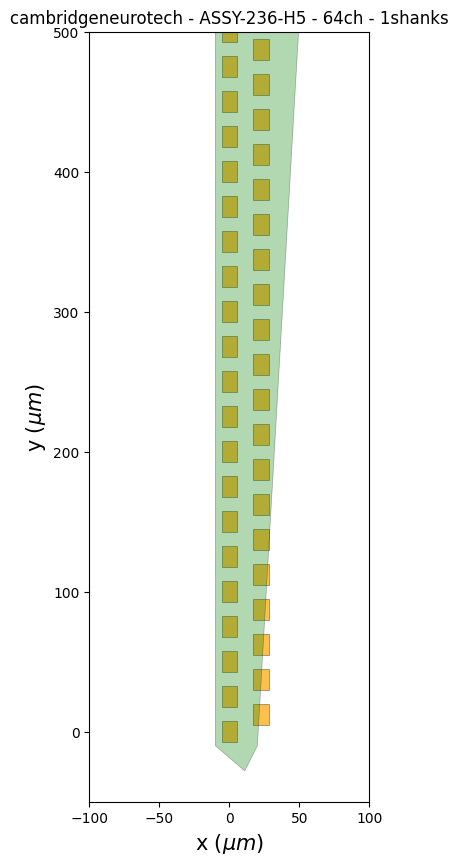

In [30]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 500)

(-50.0, 300.0)

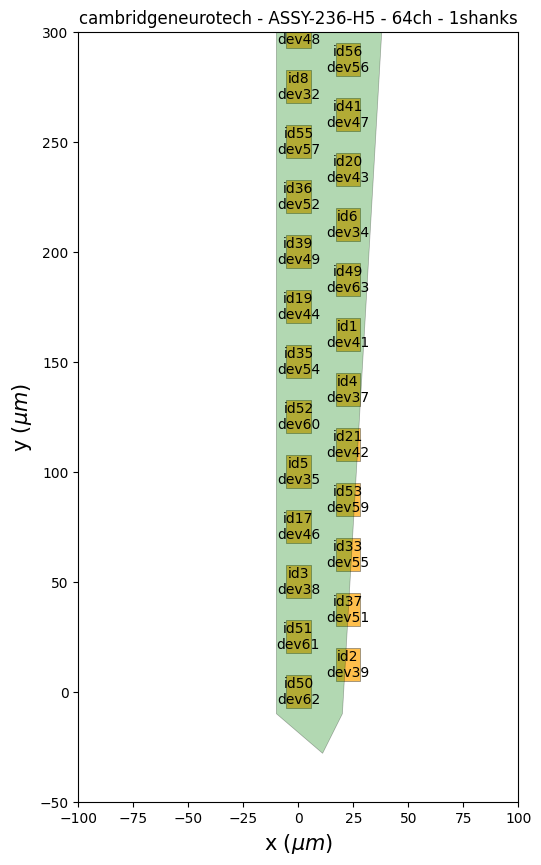

In [31]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax, with_contact_id=True, with_device_index=True,)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [32]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,,41
1,2,,39
2,3,,38
3,4,,37
4,5,,35
...,...,...,...
59,60,,4
60,61,,3
61,62,,2
62,63,,1


When loading the probe, the device indices (and all the other contact properties) are automatically sorted.
And very importantly the recording is reduce to 644 channels!

In [33]:
raw_rec = full_raw_rec.set_probe(probe)
raw_rec

ChannelSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [34]:
probe_rec = raw_rec.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "device_channel_indices"]]

,contact_ids,device_channel_indices
0,64,0
1,63,1
2,62,2
3,61,3
4,60,4
...,...,...
59,53,59
60,52,60
61,51,61
62,50,62


We can now visualize the channel_id (channel name) from open ephys.

(-50.0, 300.0)

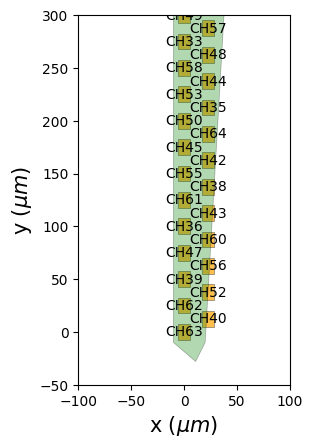

In [35]:
fig, ax = plt.subplots()
si.plot_probe_map(raw_rec, with_channel_ids=True, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The `widgets` module includes several convenient plotting functions that can be used to explore the data:

In [36]:
%matplotlib widget
si.plot_traces(raw_rec, backend="ipywidgets", mode='map')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [37]:
print("Properties:\n", list(raw_rec.get_property_keys()))

Properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group']


Let's add some new properties! 
The first 192 channels are in the CA1 area, the second 192 are in the CA3 area:

In [38]:
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [39]:
raw_rec.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [40]:
raw_rec.set_property(key='quality', values=["good"]*(raw_rec.get_num_channels() - 3),
                           ids=raw_rec.get_channel_ids()[:-3])

In [41]:
raw_rec.get_property("quality")[-10:]

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', '', '', ''],
      dtype='<U4')

In [42]:
print("Properties after adding custom properties:\n", list(raw_rec.get_property_keys()))

Properties after adding custom properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group', 'brain_area', 'quality']


**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [43]:
print(raw_rec._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group', 'brain_area', 'quality'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [44]:
raw_rec.annotate(description="Dataset for SI neuralnet 2023 tutorial")

In [45]:
print(raw_rec.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording and apply common median reference to the original recording:

In [46]:
recording_f = si.bandpass_filter(raw_rec, freq_min=300, freq_max=9000)

Let's now apply Common Median Reference (CMR):

In [47]:
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

In [49]:
w = si.plot_traces({"filt": recording_f, "common": recording_cmr}, mode='map',
                        time_range=[10, 10.1],
                        backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [50]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=300*fs)
recording_sub

FrameSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [51]:
raw_rec_sub = raw_rec.frame_slice(start_frame=0*fs, end_frame=300*fs)
raw_rec_sub

FrameSliceRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [52]:
job_kwargs = dict(n_jobs=30, chunk_duration="1s", progress_bar=True)

In [53]:
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_sub.save(folder=base_folder / "preprocessed", **job_kwargs)

write_binary_recording with n_jobs = 30 and chunk_size = 30000


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [54]:
recording_saved

BinaryFolderRecording: 64 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 1.07 GiB

In [55]:
!ls {base_folder}/preprocessed

binary.json  properties       si_folder.json
probe.json   provenance.json  traces_cached_seg0.raw


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [56]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')


Cached channels ids: ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64']


After saving the SI object, we can easily load it back in a new session:

In [57]:
recording_loaded = si.load_extractor(base_folder / "preprocessed")

In [58]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')


Loaded channels ids: ['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64']


**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the available and installed sorters in `SpikeInterface`.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [59]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [60]:
si.installed_sorters()

['spykingcircus2', 'tridesclous', 'tridesclous2']

The `spikeinterface.sortingcomponents` module includes functions that can be used to create custom spike sorting pipelines built-in in `SpikeInterface`. It is still experimental and under heavy development, but there are already two SI-based sorters available:

* `tridesclous2` (developed by Samuel Garcia)
* `spykingcircus2` (developed by Pierre Yger)

They can be run with the same `run_sorter` function, but they don't require any additional installation!

For matlab based sorter we need to set the path of the source code

In [61]:
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5/')
si.installed_sorters()

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5


['kilosort2_5', 'spykingcircus2', 'tridesclous', 'tridesclous2']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [62]:
si.get_default_sorter_params('kilosort2_5')

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'do_correction': True,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': True,
 'delete_recording_dat': False,
 'n_jobs': 40,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [63]:
si.run_sorter?

Signature:
si.run_sorter(
    sorter_name: str,
    recording: spikeinterface.core.baserecording.BaseRecording,
    output_folder: Optional[str] = None,
    remove_existing_folder: bool = True,
    delete_output_folder: bool = False,
    verbose: bool = False,
    raise_error: bool = True,
    docker_image: Union[bool, str, NoneType] = False,
    singularity_image: Union[bool, str, NoneType] = False,
    delete_container_files: bool = True,
    with_output: bool = True,
    **sorter_params,
)
Docstring:
Generic function to run a sorter via function approach.


Parameters
----------
sorter_name: str
    The sorter name
recording: RecordingExtractor
    The recording extractor to be spike sorted
output_folder: str or Path
    Path to output folder
remove_existing_folder: bool
    If True and output_folder exists yet then delete.
delete_output_folder: bool
    If True, output folder is deleted (default False)
verbose: bool
    If True, output is verbose
raise_error: bool
    If True, an e

To modify a parameter, we can easily pass it to the `run` function as an extra argument!

### Run sorter locally

In [64]:
sorter_params = {'do_correction': False}

In [65]:
# run spike sorting on entire recording
sorting_KS25 = si.run_sorter('kilosort2_5', recording_saved,
                             output_folder=base_folder / 'results_KS25',
                             verbose=True, **sorter_params, **job_kwargs)

RUNNING SHELL SCRIPT: /data_local/DataSpikeSorting/SI_tutorial_marseille_2023/results_KS25/sorter_output/run_kilosort2_5.sh


                            < M A T L A B (R) >

                  Copyright 1984-2020 The MathWorks, Inc.

              R2020a Update 2 (9.8.0.1380330) 64-bit (glnxa64)

                                May 5, 2020



 

To get started, type doc.

For product information, visit www.mathworks.com.

 

Time   0s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   2s. Loading raw data and applying filters... 

Time   8s. Finished preprocessing 138 batches. 

Drift correction DISABLED

pitch is 1.250000e+01 um

0.12 sec, 1 batches, 1780 spikes 

5.29 sec, 101 batches, 167770 spikes 

7.20 sec, 138 batches, 226503 spikes 

time 11.45, Skipped shifting 138 batches. 

Time  12s. Optimizing templates ...

12.47 sec, 1 / 138 batches, 13 units, nspks: 4.1661, mu: 48.6564, nst0: 28, merges: 0.0000, 0.0000, 0.60

We can check the output object:

In [66]:
sorting_KS25

KiloSortSortingExtractor: 156 units - 1 segments - 30.0kHz

In [67]:
sorting_KS25 = sorting_KS25.remove_empty_units()
print(f'KS25 found {len(sorting_KS25.get_unit_ids())} non-empty units')

KS25 found 156 non-empty units


SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [68]:
!ls {base_folder}/results_KS25

sorter_output		 spikeinterface_params.json
spikeinterface_log.json  spikeinterface_recording.json


In [69]:
!cat {base_folder}/results_KS25/spikeinterface_params.json

{
    "sorter_name": "kilosort2_5",
    "sorter_params": {
        "detect_threshold": 6,
        "projection_threshold": [
            10,
            4
        ],
        "preclust_threshold": 8,
        "car": true,
        "minFR": 0.1,
        "minfr_goodchannels": 0.1,
        "nblocks": 5,
        "sig": 20,
        "freq_min": 150,
        "sigmaMask": 30,
        "nPCs": 3,
        "ntbuff": 64,
        "nfilt_factor": 4,
        "NT": 65600,
        "AUCsplit": 0.9,
        "do_correction": false,
        "wave_length": 61,
        "keep_good_only": false,
        "skip_kilosort_preprocessing": false,
        "scaleproc": null,
        "save_rez_to_mat": false,
        "delete_tmp_files": true,
        "delete_recording_dat": false,
        "n_jobs": 30,
        "chunk_duration": "1s",
        "progress_bar": true,
        "mp_context": null,
        "max_threads_per_process": 1
    }
}

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [71]:
print(f'Spike train of a unit: {sorting_KS25.get_unit_spike_train(unit_id=1)}')
print(f'Spike train of a unit (in s): {sorting_KS25.get_unit_spike_train(unit_id=1, return_times=True)}')

Spike train of a unit: [    753    8618    8978 ... 8985774 8985847 8985902]
Spike train of a unit (in s): [352.9851     353.24726667 353.25926667 ... 652.4858     652.48823333
 652.49006667]


We can use `spikewidgets` functions for some quick visualizations:

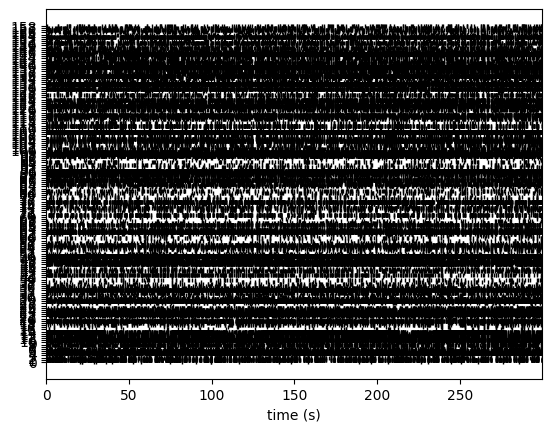

In [76]:
%matplotlib inline
w_rs = si.plot_rasters(sorting_KS25)

We can also save a spike sorting output for future use:

In [77]:
sorting_saved_KS25 = sorting_KS25.save(folder=base_folder / "sorting_KS25")

### Run sorter in container

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker/singularity installed
2. have docker/singularity python SDK installed (`pip install docker/spython`)

When docker/singularity is installed, you can simply run the sorter in a container image:

In [78]:
# run spike sorting on entire recording
sorting_KS2 = si.run_sorter('kilosort2', recording_saved, 
                            output_folder=base_folder / 'results_KS2',
                            verbose=True,
                            docker_image=True, 
                            **job_kwargs)

Starting container
Installing spikeinterface from sources in spikeinterface/kilosort2-compiled-base
Installing dev spikeinterface from remote repository
Installing extra requirements: ['neo']
Running kilosort2 sorter inside spikeinterface/kilosort2-compiled-base
Stopping container


In [79]:
print(sorting_KS2)

KiloSortSortingExtractor: 162 units - 1 segments - 30.0kHz


In [80]:
print(f'KS2 found {len(sorting_KS2.get_unit_ids())} units')

KS2 found 162 units


In [81]:
sorting_KS2 = sorting_KS2.remove_empty_units()
print(f'KS2 found {len(sorting_KS2.get_unit_ids())} non-empty units')

KS2 found 162 non-empty units


# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [82]:
recording_saved = si.load_extractor(base_folder / "preprocessed")
sorting = sorting_KS25
print(sorting)

UnitsSelectionSorting: 156 units - 1 segments - 30.0kHz


In [83]:
si.extract_waveforms?

Signature:
si.extract_waveforms(
    recording,
    sorting,
    folder=None,
    mode='folder',
    precompute_template=('average',),
    ms_before=3.0,
    ms_after=4.0,
    max_spikes_per_unit=500,
    overwrite=False,
    return_scaled=True,
    dtype=None,
    sparse=False,
    sparsity=None,
    num_spikes_for_sparsity=100,
    allow_unfiltered=False,
    use_relative_path=False,
    seed=None,
    load_if_exists=None,
    **kwargs,
)
Docstring:
Extracts waveform on paired Recording-Sorting objects.
Waveforms can be persistent on disk (`mode`="folder") or in-memory (`mode`="memory").
By default, waveforms are extracted on a subset of the spikes (`max_spikes_per_unit`) and on all channels (dense).
If the `sparse` parameter is set to True, a sparsity is estimated using a small number of spikes
(`num_spikes_for_sparsity`) and waveforms are extracted and saved in sparse mode.


Parameters
----------
recording: Recording
    The recording object
sorting: Sorting
    The sorting object

In [85]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_dense", 
                          sparse=False,
                          overwrite=True, **job_kwargs)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 64 channels - 156 units - 1 segments
  before:90 after:120 n_per_units:500


Now all waveforms are computed and stored in the provided `waveforms` folder. We can now retrieve waveforms and templates easily:

In [86]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (28, 210, 64)
Template shape: (210, 64)
All templates shape: (156, 210, 64)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

**NEW in v0.95**: we can also render interactive plots with the `ipywidgets` backend!

In [88]:
%matplotlib widget
w = si.plot_unit_templates(we,backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [89]:
for unit in sorting.get_unit_ids()[::10]:
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 28 - num spikes: 28
Unit 10 - num waveforms: 500 - num spikes: 3046
Unit 20 - num waveforms: 125 - num spikes: 125
Unit 30 - num waveforms: 238 - num spikes: 238
Unit 41 - num waveforms: 500 - num spikes: 600
Unit 51 - num waveforms: 243 - num spikes: 243
Unit 62 - num waveforms: 500 - num spikes: 3752
Unit 72 - num waveforms: 484 - num spikes: 484
Unit 82 - num waveforms: 81 - num spikes: 81
Unit 92 - num waveforms: 245 - num spikes: 245
Unit 102 - num waveforms: 500 - num spikes: 735
Unit 113 - num waveforms: 328 - num spikes: 328
Unit 123 - num waveforms: 500 - num spikes: 887
Unit 133 - num waveforms: 195 - num spikes: 195
Unit 143 - num waveforms: 500 - num spikes: 630
Unit 153 - num waveforms: 500 - num spikes: 1623


No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we could use the `max_spikes_per_unit` argument, but this would be crazy:

```
we_all = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_all", 
                              max_spikes_per_unit=None,
                              overwrite=True,
                              **job_kwargs)
```

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `postprocessing` module.

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on all channels.
In order to find a subset of channels for each unit, we can use the `compute_sparsity()` which give an object of sparsity per unit.

In [90]:
sparsity = si.compute_sparsity(we, method='radius', radius_um=100.0)
sparsity

ChannelSparsity - units: 156 - channels: 64 - density, P(x=1): 0.26

In [91]:
#  check the sparsity for some units
for unit_id in sorting.unit_ids[::30]:
    print(unit_id, list(sparsity.unit_id_to_channel_ids[unit_id]))

0 ['CH33', 'CH35', 'CH36', 'CH38', 'CH42', 'CH43', 'CH44', 'CH45', 'CH48', 'CH50', 'CH53', 'CH55', 'CH57', 'CH58', 'CH60', 'CH61', 'CH64']
30 ['CH2', 'CH3', 'CH10', 'CH11', 'CH12', 'CH13', 'CH17', 'CH19', 'CH23', 'CH25', 'CH29', 'CH34', 'CH37', 'CH46', 'CH51', 'CH54', 'CH59']
62 ['CH36', 'CH38', 'CH39', 'CH40', 'CH43', 'CH47', 'CH52', 'CH55', 'CH56', 'CH60', 'CH61', 'CH62', 'CH63']
92 ['CH2', 'CH10', 'CH23', 'CH33', 'CH34', 'CH37', 'CH41', 'CH44', 'CH46', 'CH48', 'CH49', 'CH51', 'CH53', 'CH54', 'CH57', 'CH58', 'CH59']
123 ['CH1', 'CH4', 'CH5', 'CH6', 'CH7', 'CH9', 'CH16', 'CH20', 'CH21', 'CH22', 'CH24', 'CH26', 'CH27', 'CH28', 'CH30', 'CH31', 'CH32']
153 ['CH1', 'CH4', 'CH5', 'CH6', 'CH7', 'CH9', 'CH16', 'CH20', 'CH21', 'CH22', 'CH24', 'CH26', 'CH27', 'CH28', 'CH30', 'CH31', 'CH32']


In [ ]:
## lets use this sparsity object to extract waveforms again

In [93]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse_explicit", 
                          sparsity=sparsity, **job_kwargs)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 64 channels - 156 units - 1 segments
  before:90 after:120 n_per_units:500 - sparse


In [95]:
# the waveforms are now sparse
for unit_id in we.unit_ids[::10]:
    waveforms = we.get_waveforms(unit_id=unit_id)
    print(unit_id, waveforms.shape)

0 (28, 210, 17)
10 (500, 210, 17)
20 (125, 210, 15)
30 (238, 210, 17)
41 (500, 210, 17)
51 (243, 210, 17)
62 (500, 210, 13)
72 (484, 210, 17)
82 (81, 210, 17)
92 (245, 210, 17)
102 (500, 210, 17)
113 (328, 210, 17)
123 (500, 210, 17)
133 (195, 210, 17)
143 (500, 210, 17)
153 (500, 210, 17)


we can also auto estimate the sparsity directly on waveforms extraction, this avoid extacting twice (one dense + one sparse)

In [96]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse", 
                          sparse=True, **job_kwargs)
print(we)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 64 channels - 156 units - 1 segments
  before:90 after:120 n_per_units:500 - sparse


In [97]:
# and we can acces the sparsity as an attributes of the object
print(we.sparsity)

ChannelSparsity - units: 156 - channels: 64 - density, P(x=1): 0.26


Most of the plotting and exporting functions accept `sparsity` as an argument. 

In [98]:
%matplotlib widget
si.plot_unit_templates(we, backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [99]:
si.compute_principal_components?

Signature:
si.compute_principal_components(
    waveform_extractor,
    load_if_exists=False,
    n_components=5,
    mode='by_channel_local',
    sparsity=None,
    whiten=True,
    dtype='float32',
    tmp_folder=None,
    **job_kwargs,
)
Docstring:
Compute PC scores from waveform extractor. The PCA projections are pre-computed only
on the sampled waveforms available from the WaveformExtractor.

Parameters
----------
waveform_extractor: WaveformExtractor
    The waveform extractor
load_if_exists: bool
    If True and pc scores are already in the waveform extractor folders, pc scores are loaded and not recomputed.
n_components: int
    Number of components fo PCA - default 5
mode: str, default: 'by_channel_local'
    - 'by_channel_local': a local PCA is fitted for each channel (projection by channel)
    - 'by_channel_global': a global PCA is fitted for all channels (projection by channel)
    - 'concatenated': channels are concatenated and a global PCA is fitted
sparsity: ChannelSpar

In [100]:
pc = si.compute_principal_components(we, n_components=3,
                                        load_if_exists=False,
                                         **job_kwargs)
                                        # n_jobs=job_kwargs["n_jobs"], 
                                        # progress_bar=job_kwargs["progress_bar"])

Fitting PCA:   0%|          | 0/156 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/156 [00:00<?, ?it/s]

In [101]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (28, 3, 64)
All PC scores shape: (54902, 3, 64)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 

## WaveformExtensions

When we compute PCA (or use other postprocessing functions), the computed information is added to the waveform folder. The functions act as `WaveformExtensions`:

In [102]:
we.get_available_extension_names()

['principal_components']

Each `WaveformExtension` is an object that allows us to retrieve the data:

In [103]:
pc = we.load_extension("principal_components")
print(pc)

WaveformPrincipalComponent: 64 channels - 1 segments
  mode: by_channel_local n_components: 3


In [104]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

(54902, 3, 64)


### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [105]:
amplitudes = si.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True, 
                                            **job_kwargs)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

By default, all amplitudes are concatenated in one array with all amplitudes form all spikes. With the `output="by_unit"` argument, instead, a dictionary is returned:

In [109]:
amplitudes[0][15]

array([ -30.419998 ,  -38.609997 ,  -50.309998 ,  -47.969997 ,
        -17.744999 ,  -53.624996 ,  -29.835    ,  -19.695    ,
         -9.945    ,  -50.114998 ,  -37.05     ,  -38.219997 ,
        -28.275    ,  -35.684998 ,  -16.574999 ,  -10.335    ,
        -28.859999 ,  -27.494999 ,  -40.949997 ,   -6.825    ,
        -32.37     ,    3.8999999,  -45.434998 ,    1.9499999,
        -19.304998 ,  -47.579998 ,  -37.245    ,  -33.149998 ,
        -46.019997 ,  -15.405    ,  -24.57     ,  -50.699997 ,
        -23.789999 ,  -70.784996 ,  -23.009998 ,  -46.215    ,
        -17.744999 ,  -21.644999 ,  -43.875    ,  -17.355    ,
        -22.425    , -102.17999  ,  -24.765    ,  -11.115    ,
        -76.049995 ,  -28.079998 ,  -30.419998 ,  -38.609997 ,
        -40.754997 ,   -2.34     ,  -27.105    ,  -58.89     ,
        -31.199999 ,  -13.259999 ,  -15.209999 ,  -33.93     ,
          6.825    ,  -46.019997 ,  -31.784998 ], dtype=float32)

In [111]:
%matplotlib widget
si.plot_amplitudes(we, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [112]:
unit_locations = si.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = si.compute_spike_locations(we, method="center_of_mass", load_if_exists=True,
                                                **job_kwargs)

localize peaks using center_of_mass:   0%|          | 0/300 [00:00<?, ?it/s]

In [113]:
%matplotlib widget
si.plot_unit_locations(we, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

In [114]:
%matplotlib widget
si.plot_spike_locations(we, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

### Compute correlograms

In [115]:
ccgs, bins = si.compute_correlograms(we)

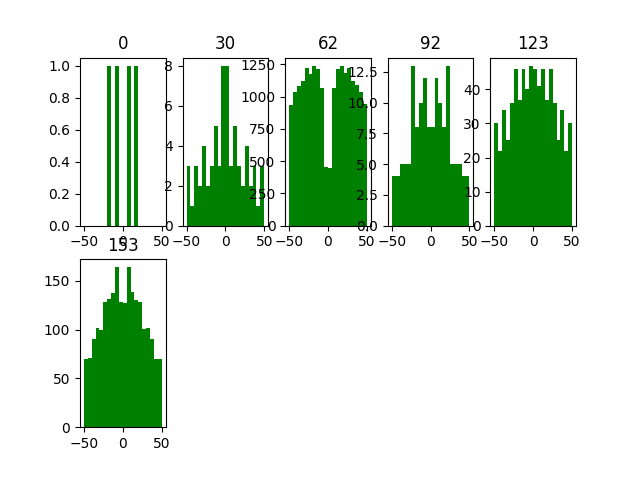

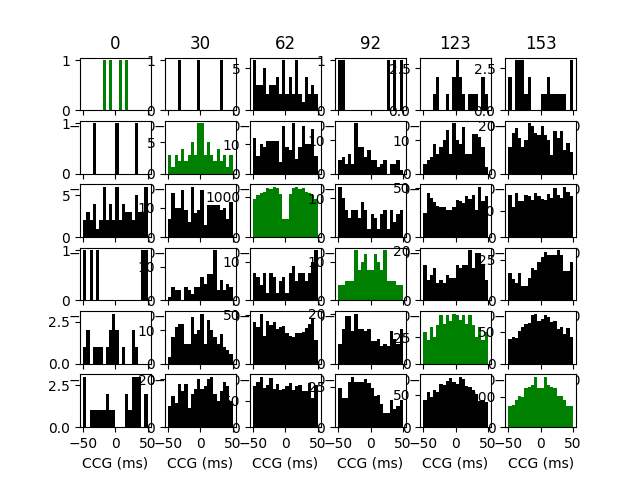

In [116]:
si.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[::30])
si.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[::30])

### Compute template similarity

In [117]:
similarity = si.compute_template_similarity(we)

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [118]:
print(si.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [119]:
template_metrics = si.calculate_template_metrics(we)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
0,0.001307,-0.391404,0.002547,48476.864899,-8091.106912
1,0.00091,-0.718196,0.00051,67656.518883,-40346.732642
2,0.001247,-0.383722,0.000583,31044.807676,-8154.301684
3,0.001403,-0.403558,0.002477,30632.380047,-14144.407076
4,0.000957,-0.262174,0.000313,83241.985996,-13414.717287
...,...,...,...,...,...
154,0.000383,-0.412954,0.00024,172016.85597,-19284.025537
155,0.000917,-0.341462,0.000313,114168.149826,-26819.953742
156,0.000873,-0.289673,0.000357,139584.766679,-21248.883083
157,0.000947,-0.285544,0.00029,168796.452655,-34604.336427


In [120]:
si.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
                         backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [121]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [122]:
metric_names = si.get_quality_metric_list()
qm = si.compute_quality_metrics(we, metric_names=metric_names, verbose=True, **job_kwargs)


Computing num_spikes
Computing firing_rate
Computing presence_ratio
Computing snr
Computing isi_violation
Computing rp_violation
Computing sliding_rp_violation
Computing amplitude_cutoff
Computing amplitude_median
Computing amplitude_cv
Computing synchrony
Computing firing_range
Computing drift


In [123]:
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad
0,28.0,0.093333,1.0,4.774624,0.000000,0,0.000000,0,NaN,NaN,33.832500,NaN,NaN,0.142857,0.0,0.0,0.40,NaN,NaN,NaN
1,3114.0,10.380000,1.0,4.569558,3.588740,348,1.000000,155,NaN,0.000312,30.029999,0.443721,0.262773,0.037893,0.0,0.0,13.96,0.691679,0.248978,0.225388
2,1342.0,4.473333,1.0,3.069844,0.499732,9,0.976864,6,NaN,0.003305,23.984999,0.576678,0.227289,0.111773,0.0,0.0,6.41,0.423405,0.165835,0.139202
3,163.0,0.543333,1.0,3.805212,3.763785,1,1.000000,1,NaN,NaN,26.519999,NaN,NaN,0.116564,0.0,0.0,1.20,NaN,NaN,NaN
4,3502.0,11.673333,1.0,6.294980,0.913242,112,1.000000,79,NaN,0.000252,32.369999,0.370751,0.302970,0.032838,0.0,0.0,5.81,0.215339,0.078740,0.074157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,375.0,1.250000,1.0,5.037415,0.000000,0,0.000000,0,NaN,NaN,31.784998,NaN,NaN,0.037333,0.0,0.0,2.01,NaN,NaN,NaN
155,343.0,1.143333,1.0,6.907933,0.000000,0,0.000000,0,NaN,NaN,46.799999,NaN,NaN,0.084548,0.0,0.0,1.42,NaN,NaN,NaN
156,733.0,2.443333,1.0,8.258265,1.302837,7,1.000000,4,NaN,0.002302,50.894997,0.338767,0.420852,0.045020,0.0,0.0,2.21,1.613493,0.568305,0.353003
157,456.0,1.520000,1.0,11.431896,0.000000,0,0.000000,0,NaN,NaN,73.125000,NaN,NaN,0.057018,0.0,0.0,1.40,NaN,NaN,NaN


In [124]:
si.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
                        backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold < 0.2 and amplitude cutoff < 0.9:

In [125]:
isi_viol_thresh = 0.2
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [126]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.2


and then we can use the query to select units:

In [127]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values

In [128]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 156
Number of units after curation: 16


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [129]:
we_curated = we.select_units(keep_unit_ids, new_folder=base_folder / "waveforms_curated")

In [130]:
print(we_curated)

WaveformExtractor: 64 channels - 16 units - 1 segments
  before:90 after:120 n_per_units:500 - sparse


In [131]:
we_curated.get_available_extension_names()

['template_metrics',
 'similarity',
 'principal_components',
 'spike_amplitudes',
 'correlograms',
 'spike_locations',
 'unit_locations',
 'quality_metrics']

# 8. Viewers <a class="anchor" id="viewers"></a>


### SpikeInterface GUI

A QT-based GUI built on top of SpikeInterface objects.

Developed by Samuel Garcia, CRNL, Lyon.

In [223]:
# !sigui {base_folder}/waveforms_sparse

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html).

Developed by Jeremy Magland and Jeff Soules, Flatiron Institute, NYC

In [134]:
# w = si.plot_sorting_summary(we_curated, backend="sortingview")

# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

### Compare two sorters

In [135]:
comp_KS2_KS25 = si.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

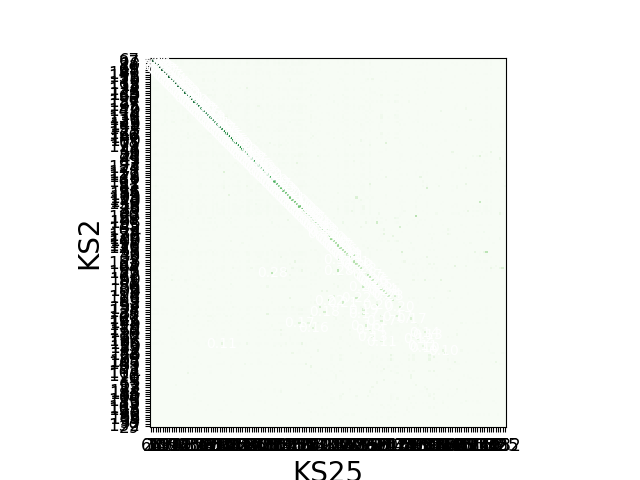

In [136]:
si.plot_agreement_matrix(comp_KS2_KS25)

In [137]:
comp_KS2_KS25auto = si.compare_two_sorters(sorting_KS2, sorting_auto_KS25, 'KS2', 'KS25_auto')

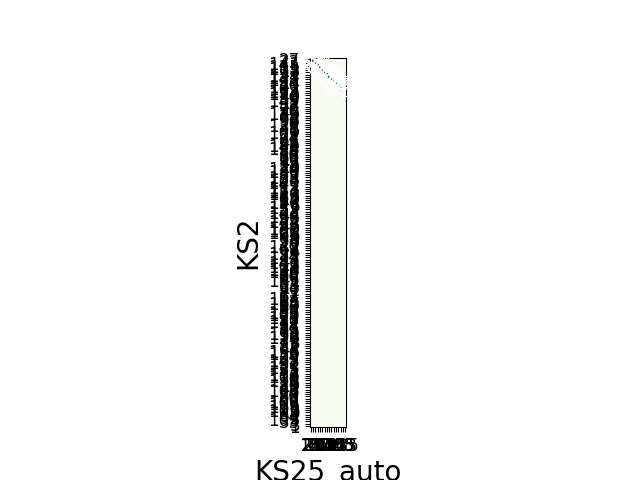

In [138]:
si.plot_agreement_matrix(comp_KS2_KS25auto)

### Compare multiple sorters

In [139]:
mcmp = si.compare_multiple_sorters([sorting_KS2, sorting_KS25], ['KS2', 'KS25'], 
                                   spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing: KS2 and KS25
Multicomparison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


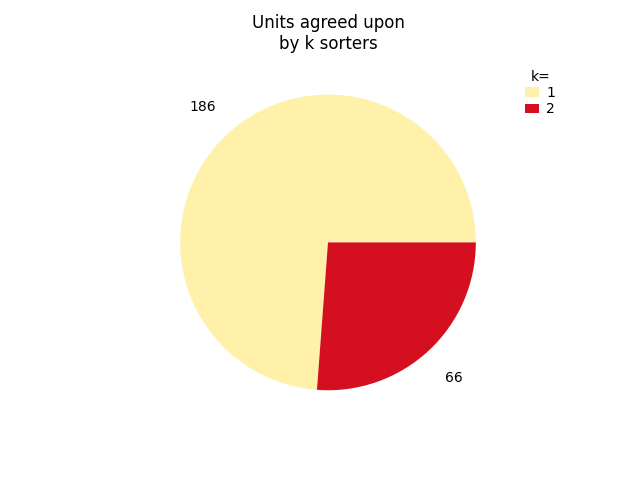

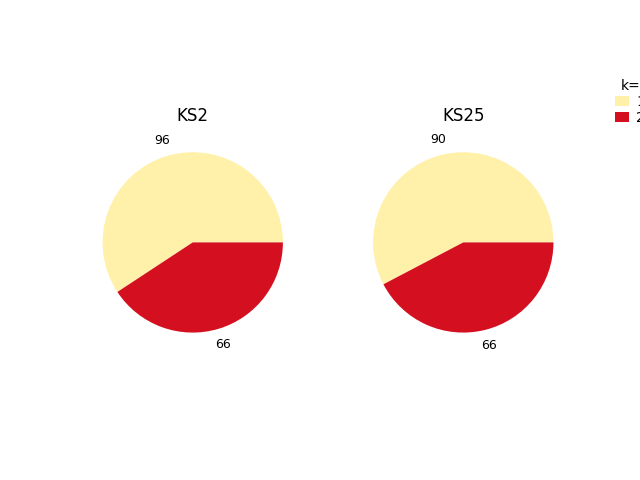

In [140]:
w = si.plot_multicomp_agreement(mcmp)
w = si.plot_multicomp_agreement_by_sorter(mcmp)

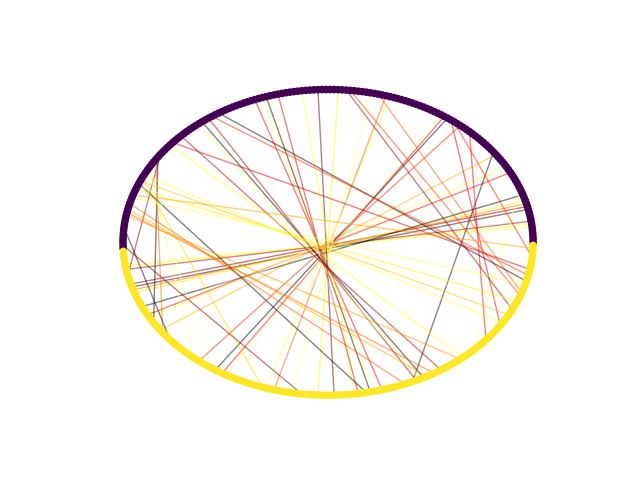

In [141]:
si.plot_multicomp_graph(mcmp, draw_labels=False)

In [142]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print(agreement_sorting)

AgreementSortingExtractor: 66 units - 1 segments - 30.0kHz


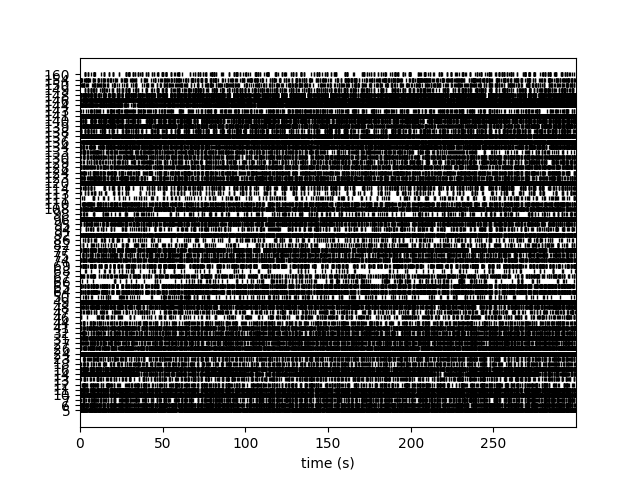

In [143]:
si.plot_rasters(agreement_sorting)

In [144]:
# compare consensus and auto
comp_agr_auto = si.compare_two_sorters(agreement_sorting, sorting_auto_KS25, 'AGR', 'AUTO')

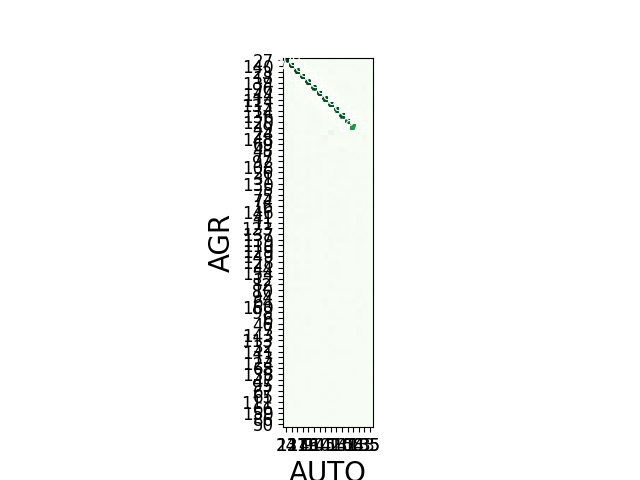

In [145]:
si.plot_agreement_matrix(comp_agr_auto)

# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [146]:
si.export_to_phy?

Signature:
si.export_to_phy(
    waveform_extractor: 'WaveformExtractor',
    output_folder: 'str | Path',
    compute_pc_features: 'bool' = True,
    compute_amplitudes: 'bool' = True,
    sparsity: 'Optional[ChannelSparsity]' = None,
    copy_binary: 'bool' = True,
    remove_if_exists: 'bool' = False,
    peak_sign: "Literal['both', 'neg', 'pos']" = 'neg',
    template_mode: 'str' = 'median',
    dtype: 'Optional[npt.DTypeLike]' = None,
    verbose: 'bool' = True,
    use_relative_path: 'bool' = False,
    **job_kwargs,
)
Docstring:
Exports a waveform extractor to the phy template-gui format.

Parameters
----------
waveform_extractor: a WaveformExtractor or None
    If WaveformExtractor is provide then the compute is faster otherwise
output_folder: str | Path
    The output folder where the phy template-gui files are saved
compute_pc_features: bool
    If True (default), pc features are computed
compute_amplitudes: bool
    If True (default), waveforms amplitudes are computed
sparsi

In [147]:
si.export_to_phy(we, output_folder=base_folder / 'phy_KS25', 
                   compute_amplitudes=False, compute_pc_features=False, copy_binary=False,
                   **job_kwargs)

Run:
phy template-gui  /data_local/DataSpikeSorting/SI_tutorial_marseille_2023/phy_KS25/params.py


After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
sorting_phy_curated = se.PhySortingExtractor(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])

## Export a report to a folder



In [148]:
si.export_report(we, output_folder=base_folder / 'report_KS25')

### Et voilà!